In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

---
# A notebook to train the fwrf on vision and imagery voxel responses.
---
<a id='back_to_top'></a>

## Major sections
* [0. Preliminary Setup](#prim_setup)                       
* [1. Load the dataset](#load_data)  
* [2. Create the feature space and generate model-space tensor](#create_mst)
* [3. Model selection and training](#training)

## Imports

In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from glob import glob
import scipy.io as sio
from scipy import ndimage as nd
from scipy.stats import pearsonr
from scipy import misc
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import PIL.Image as pim
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

import src.fwrf as fwrf
import src.feature_space as fs
import src.numpy_utility as pnu

from   src.plots import display_candidate_loss, plot_rf_as_circles   ## will need to be added to final repo
from   src.load_data import load_grayscale_stimuli,  load_zscored_voxels, load_voxels, split_mask
from   src.file_utility import load_mask_from_nii, view_data

fpX = fwrf.fpX

/usr/local/lib/python2.7/dist-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


theano floatX: float32
numpy floatX: <type 'numpy.float32'>


Using cuDNN version 7605 on context None
Preallocating 7265/24217 Mb (0.300000) on cuda0
Mapped name None to device cuda0: TITAN RTX (0000:05:00.0)


## Global variables
### Subject and input directory

In [3]:
subject_dir = 'CO_new/'
dataset_dir = "/home/styvesg/Documents/PostDoc/Datasets/imagery_rf/" + subject_dir
print dataset_dir

/home/styvesg/Documents/PostDoc/Datasets/imagery_rf/CO_new/


### Create output directory if it does not exist

In [4]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

root_dir   = os.getcwd() + '/'
output_dir = root_dir+"output/"+subject_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print "Output dir: %s" % output_dir
print "Time Stamp: %s" % timestamp

Output dir: /home/styvesg/Documents/PostDoc/GitRepo/imagery-master/output/CO_new/
Time Stamp: Mar-06-2020_1516


### Graphics global and print options

In [5]:
saveext = ".png"
savearg = {'format':'png', 'dpi': 300}

sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

<a id='load_data'></a>
# 1. Load the dataset 
## Load the image dataset
(the images that were presented to the subject for which we have voxel data)

[back to top](#back_to_top)

In [6]:
npx = 600 # resolution at which to load (600 is the native resolution for this dataset)
stim_data, stimuli_meta = load_grayscale_stimuli(dataset_dir, npx)

## Separate the pcp and img sets into matching presentation set

In [7]:
pcp_mask, img_mask = split_mask(stimuli_meta)

pcp_stim_data = stim_data[pcp_mask]
img_stim_data = stim_data[img_mask]

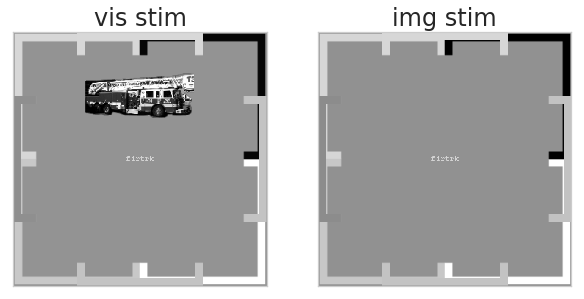

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(pcp_stim_data[0,0,:,:], cmap='gray')
plt.title('vis stim')
plt.grid(False)
_=plt.xticks([])
_=plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(img_stim_data[0,0,:,:], cmap='gray')
plt.title('img stim')
plt.grid(False)
_=plt.xticks([])
_=plt.yticks([])

## Load the corresponding voxel data

In [9]:
voxel_data, voxel_meta = load_voxels(dataset_dir) # load_voxels

pcp_voxel_data = voxel_data[pcp_mask,...]
img_voxel_data = voxel_data[img_mask,...]

nv = pcp_voxel_data.shape[1]
print "Full voxel count: %d" % nv

Full voxel count: 349839


In [10]:
project = voxel_meta['project']
subject = voxel_meta['subject']
voxel_mask = voxel_meta['voxel_mask']
voxel_roi  = voxel_meta['roi_mask']
voxel_idx  = voxel_meta['idxs']
voxel_grid = voxel_meta['grid']
roi_map  = voxel_meta['roi_map']

## Display an arbitrary slice of the brain mask and ROIs

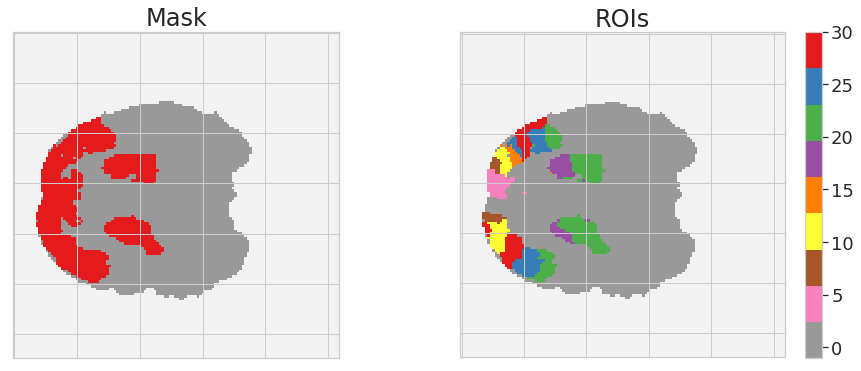

In [11]:
volume_mask = view_data(voxel_grid, voxel_idx, voxel_mask)
volume_roi = view_data(voxel_grid, voxel_idx, voxel_roi)

fig = plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(volume_mask[:,:,15], cmap='Set1_r', interpolation='None')
plt.title('Mask')
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,2,2)
plt.imshow(volume_roi[:,:,15], cmap='Set1_r', interpolation='None')
plt.colorbar()
plt.title('ROIs')
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

## (Optional) Restrict voxels to labelled ROI

In [12]:
voxel_mask=voxel_mask.astype(bool)
nv = np.sum(voxel_mask)
print "Full voxel count over all ROIs: %d" % nv

pcp_voxel_data = pcp_voxel_data[:,voxel_mask]
img_voxel_data = img_voxel_data[:,voxel_mask]

voxel_idx = voxel_idx[voxel_mask]
voxel_roi = voxel_roi[voxel_mask]

Full voxel count over all ROIs: 46909


<a id='create_mst'></a>
# 2. Create the feature space and generate model-space tensor
The model space tensor is a convenience intermediary point between the feature space and the model regression of the fwRF model. Calculating the model-space tensor explicitly once and for all results in more efficient modelling.

[back to top](#back_to_top)

## Geometry of the experiment

In [13]:
from math import degrees, atan2
native_stim_size = npx  ##pixels
viewing_distance = 103 ##cm
viewing_area = 38.8 #/ 2 ##cm
aspect_ratio = float(3)/4
# Calculate the number of degrees that correspond to a single pixel. This will
# generally be a very small value, something like 0.03.
deg_per_px = degrees(atan2(.5*viewing_area, viewing_distance)) / (.5*native_stim_size) * aspect_ratio
# Calculate the size of the stimulus in degrees
size_in_deg = native_stim_size * deg_per_px
print 'The size of the stimulus is %s pixels and %s visual degrees' % (native_stim_size, size_in_deg)
print '%f pixels correspond to one degree' % (1./deg_per_px)

The size of the stimulus is 600 pixels and 16.0000028474 visual degrees
37.499993 pixels correspond to one degree


## Create feature maps suitable for the occasion

In [14]:
gabor_params = {
    'n_orientations': 4,
    'deg_per_stimulus': size_in_deg,      ## COARSE  ## FINE
    'lowest_sp_freq': 0.35, ##cyc/deg     ## 0.96    ## 0.35
    'highest_sp_freq': 11.,               ## 8.23    ## 11.
    'num_sp_freq': 12,                    ## 8       ## 12
    'pix_per_cycle': 4.13,                ## 2.13    ## 4.13
    'complex_cell': True,
    'n_colors': 1,                        ## let's do grayscale first
    'diams_per_filter': 4.,
    'cycles_per_radius': 1.
}

log_act_func = lambda x: np.log(1+np.sqrt(x))

In [15]:
pcp_fmaps, freq, env, ori, freq_rlist, ori_rlist, fmaps_sizes, nf = fs.create_gabor_feature_maps(\
    pcp_stim_data, gabor_params=gabor_params, nonlinearity=log_act_func)

{'pix_per_cycle': 4.13, 'cycles_per_radius': 1.0, 'deg_per_stimulus': 16.000002847402424, 'n_colors': 1, 'complex_cell': True, 'num_sp_freq': 12, 'diams_per_filter': 4.0, 'highest_sp_freq': 11.0, 'n_orientations': 4, 'lowest_sp_freq': 0.35}
allocating memory for feature maps
constructing feature maps
feature 0 took 0.183769 s.
feature 1 took 0.202235 s.
feature 2 took 0.225977 s.
feature 3 took 0.260473 s.
feature 4 took 0.301049 s.
feature 5 took 0.383448 s.
feature 6 took 0.554337 s.
feature 7 took 0.851057 s.
feature 8 took 1.398871 s.
feature 9 took 2.429112 s.
feature 10 took 4.235608 s.
feature 11 took 7.734017 s.
feature 12 took 0.174335 s.
feature 13 took 0.190975 s.
feature 14 took 0.198012 s.
feature 15 took 0.233625 s.
feature 16 took 0.293508 s.
feature 17 took 0.376885 s.
feature 18 took 0.557160 s.
feature 19 took 0.863042 s.
feature 20 took 1.401694 s.
feature 21 took 2.392493 s.
feature 22 took 4.263505 s.
feature 23 took 7.781334 s.
feature 24 took 0.176781 s.
feature 

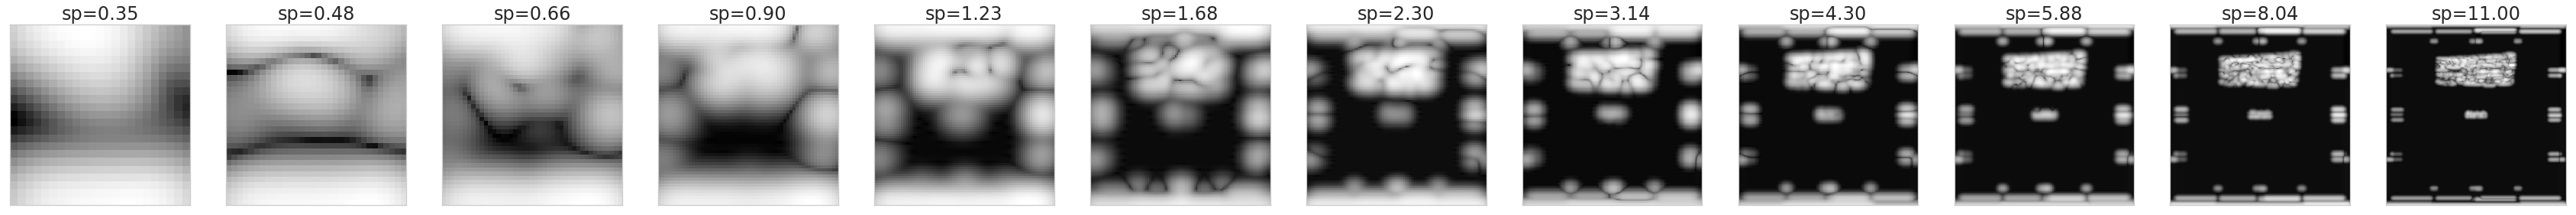

In [16]:
plt.figure(figsize=(5*len(pcp_fmaps),5))
for k,(f,fm) in enumerate(zip(freq, pcp_fmaps)):
    plt.subplot(1,len(pcp_fmaps),k+1)
    plt.imshow(fm[0,0,:,:], cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.title('sp=%.02f'%f)
    #plt.colorbar()

## Choose the receptive field parameters for the model-space tensor
Set the global hyperparameters of the receptive field candidate space and initialize parameters

In [17]:
view_angle = size_in_deg     ## COARSE                 ## FINE
nx = ny = 21                 ##nx = ny = 10            ## nx = ny = 21
smin, smax = .22, 8.75       ##smin, smax = .73, 4.37  ## smin, smax = .22, 8.75
ns = 12                      ##ns = 6                  ## ns = 12

model_specs = [[(0., view_angle), (0., view_angle), (smin, smax)], [fwrf.linspace(nx), fwrf.linspace(ny), fwrf.logspace(ns)]]
# initial values of the fwrf model parameters
voxel_params_init = [fwrf.zeros_init, fwrf.zeros_init]

rf_models = fwrf.model_space(model_specs)
print rf_models.shape

(5292, 3)


### Show the position (on a size axis) of the feature pooling envelope and the selected candidate receptive field sizes
The receptive field size should always be in a range such that the smallest receptive field is larger than the smallest pooling field and the largest receptive field is larger than the largest pooling field.

Text(0.5,1,'Distribution of feature pooling (FP) envelope and receptive field (RF) sizes')

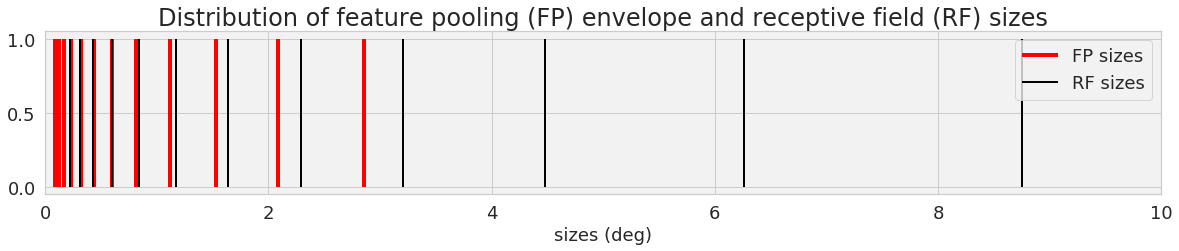

In [18]:
sigmas = np.unique(rf_models[:,2])

fig_1 = plt.figure(figsize=(20,3))
plt.vlines(env, 0., 1., lw=4, color='r', label='FP sizes')
plt.vlines(sigmas, 0., 1., lw=2, color='k', label='RF sizes')
#plt.xscale('log')
plt.xlabel('sizes (deg)')
plt.legend()
plt.xlim([0, 10])
plt.title('Distribution of feature pooling (FP) envelope and receptive field (RF) sizes')

### Display example of the feature pooling field (f.p.f.) corresponding to the $i^\mathrm{th}$ choice of receptive field (RF)

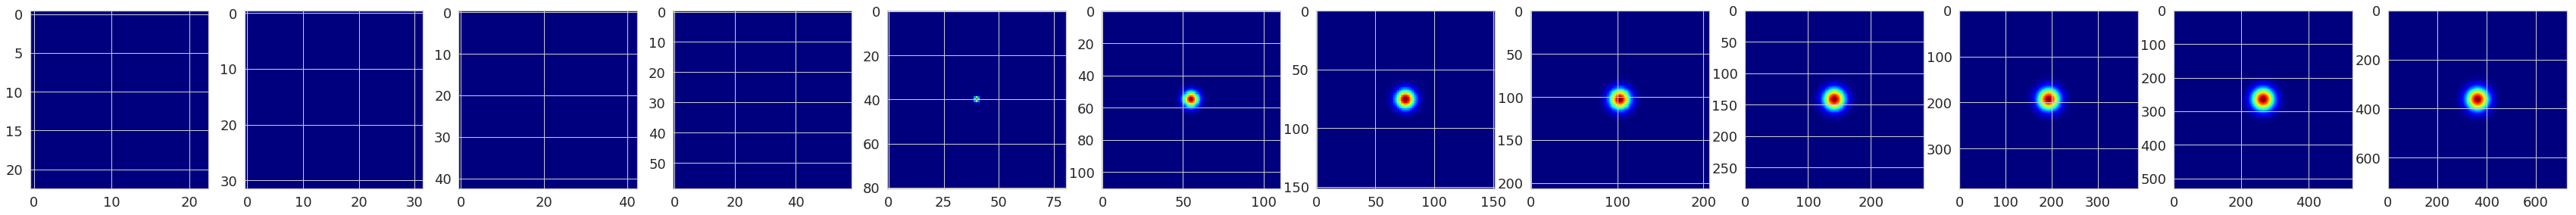

In [19]:
ith_rf_size = 4

plt.figure(figsize=(5*len(fmaps_sizes),5))
for i,r in enumerate(fmaps_sizes):
    sigma = np.sqrt(np.square(sigmas[ith_rf_size]) - np.square(env[i]))
    if(np.isnan(sigma)):
        sigma =0
    _,_,z = pnu.make_gaussian_mass(0., 0., sigma, r[2], size=20.)
    plt.subplot(1,len(fmaps_sizes),i+1)
    plt.imshow(z, interpolation='None', cmap='jet')
    #plt.colorbar()

## Evaluate the modelspace tensor
Imagery and vision runs share the same model-space tensor

In [20]:
pcp_mst_data, pcp_mst_avg, pcp_mst_std = fwrf.model_space_tensor(pcp_fmaps, \
    rf_models, feature_envelopes=env, \
    nonlinearity=None, \
    zscore=True, trn_size=len(pcp_stim_data),\
    epsilon=1e-6, batches=(200, nx*ny), \
    view_angle=view_angle, verbose=True, dry_run=False)
print pcp_mst_data.shape
print np.amin(pcp_mst_data), np.amax(pcp_mst_data)

CREATING SYMBOLS

> feature map candidates 0 with shape (1, 441, 23, 23)
> feature map candidates 1 with shape (1, 441, 32, 32)
> feature map candidates 2 with shape (1, 441, 43, 43)
> feature map candidates 3 with shape (1, 441, 59, 59)
> feature map candidates 4 with shape (1, 441, 81, 81)
> feature map candidates 5 with shape (1, 441, 111, 111)
> feature map candidates 6 with shape (1, 441, 152, 152)
> feature map candidates 7 with shape (1, 441, 207, 207)
> feature map candidates 8 with shape (1, 441, 284, 284)
> feature map candidates 9 with shape (1, 441, 388, 388)
> feature map candidates 10 with shape (1, 441, 531, 531)
> feature map candidates 11 with shape (1, 441, 727, 727)
  total number of feature maps = 48, in 12 layers
  feature map candidate using approx 1906.7 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.484Gb of RAM!
>> Will be divided in chunks of 0.040Gb of VRAM!

COMPILING...
1.33 seconds to compile theano functions

Preco

100%|██████████| 12/12 [04:17<00:00, 21.47s/it]

5292 mst candidate responses took 257.652s @ 20.539 models/s
Z-scoring modelspace tensor...
Using self z-scoring values.



12it [00:01,  6.26it/s]


(512, 48, 1, 5292)
-22.467365 22.59159


<a id='training'></a>
# 3. Model selection and training
## Select how the training set is broken down into parts for the k-out training.

[back to top](#back_to_top)

In [21]:
lambdas = np.logspace(-5.,3.,12)
num_val_part = 16 # 16
data_size = len(pcp_voxel_data)
val_part_size = data_size/num_val_part 
trn_size = data_size-val_part_size
tho_size = int(float(trn_size)*0.4)

### COARSE                            # FINE
#num_val_part = 8                     #num_val_part = 16
#tho_size = int(float(trn_size)*0.4)  tho_size = int(float(trn_size)*0.5)

assert np.modf(float(data_size)/val_part_size)[0]==0.0, "num_val_part (%d) has to be an exact divisor of the set size (%d)" % (num_val_part, data_size)
print "trn_size = %d (incl. holdout), holdout_size = %d, val_size = %d" % (trn_size, tho_size, val_part_size)

trn_size = 480 (incl. holdout), holdout_size = 192, val_size = 32


---
## (Optional) Test on a subset for a single batch

In [22]:
val_sample_order = np.arange(data_size)
np.random.shuffle(val_sample_order)

### model training
kout_models = fwrf.kout_learn_params_ridge_regression(pcp_mst_data, pcp_voxel_data, val_sample_order, lambdas,\
                    voxel_batch_size=1000, val_part_size=val_part_size, holdout_size=tho_size, verbose=False, dry_run=False, test_run=True)
### convert to real space
kout_models = fwrf.kout_real_space_model(kout_models, rf_models, mst_avg=pcp_mst_avg, mst_std=pcp_mst_std)

print kout_models.keys()
print kout_models[0].keys()

trn_size = 480 (incl. holdout), holdout_size = 192, val_size = 32

####################################
### Test run 1000 of 46909 voxels ###
####################################
COMPILING
0.94 seconds to compile theano functions


100%|██████████| 5292/5292 [01:33<00:00, 56.64it/s]


-------------------------
total time = 93.429120s
total throughput = 0.093429s/voxel
voxel throughput = 0.018593s/voxel
setup throughput = 0.014141s/candidate


100%|██████████| 1000/1000 [00:00<00:00, 9977.34it/s]

[0, 'val_cc', 'val_pred', 'n_parts']
['rf_params', 'norm_std', 'w_params', 'norm_avg', 'val_mask', 'candidates', 'scores', 'lambdas']


Text(0.5,1,'validation accuracy')

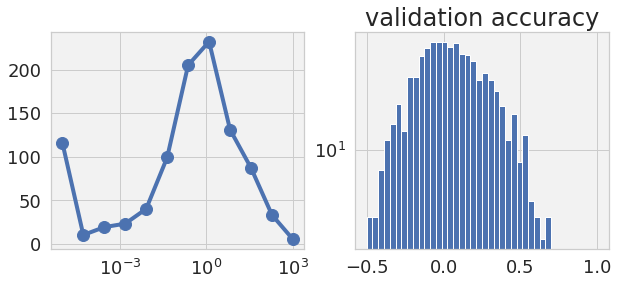

In [23]:
best_lambdas = kout_models[0]['lambdas']
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lambdas, [np.sum(best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log')
plt.subplot(1,2,2)
_=plt.hist(kout_models['val_cc'], bins=40, range=(-.5, 1.))
plt.yscale('log')
plt.title('validation accuracy')

---
## Create the output dictionary

In [24]:
models = {'project': project,
         'subject': subject,
         'model_name': 'gabor-iso-fwrf',
         'aperture': view_angle,
         'grid_size': (nx,ny,ns),
         'grid_range': model_specs[0],
         'rf_models': rf_models,
         'gabor_params': gabor_params,
         'freq': freq,
         'env': env,
         'ori': ori,
         'freq_rlist': freq_rlist,
         'ori_rlist': ori_rlist,       
         'mst_norm_avg': pcp_mst_avg, 
         'mst_norm_std': pcp_mst_std,
         'fmaps_count': nf,
         'fmaps_sizes': fmaps_sizes,
         'voxel_grid': voxel_grid,
         'voxel_mask': voxel_mask,
         'voxel_idx': voxel_idx,
         'voxel_roi': voxel_roi,
         'roi_map': roi_map,
         'lambda_params': lambdas,
         'n_parts': num_val_part,
         'val_size': val_part_size,
         'trn_size': trn_size,
         'tho_size': tho_size} 

## Run the models (by parts)
At the end of the process, we do not have a single model but several models for different part of the training set i.e. different part of the training set play the role of the validation set in turn. The advantage of this is that we can make the validatation set as small as we can and yet we'll retain the full length of the dataset to aggregate validation statistics at the end.

In [25]:
voxels = {'img': img_voxel_data,
          'pcp': pcp_voxel_data}

for run in voxels.keys():
    val_sample_order = np.arange(data_size)
    np.random.shuffle(val_sample_order)
    ### fit all the folds
    kout_models = fwrf.kout_learn_params_ridge_regression(pcp_mst_data, voxels[run], val_sample_order, lambdas,\
                    voxel_batch_size=2000, val_part_size=val_part_size, holdout_size=tho_size, verbose=False, dry_run=False, test_run=False)
    ### update kout_models with real space values
    kout_models = fwrf.kout_real_space_model(kout_models, rf_models, mst_avg=pcp_mst_avg, mst_std=pcp_mst_std)    
    models[run] = kout_models
    ###
    model_file_name = output_dir + "fwrf_%s_%s_data.pkl" % (subject, timestamp)
    model_file = open(model_file_name, 'wb')
    pickle.dump(models, model_file)
    model_file.close()

trn_size = 480 (incl. holdout), holdout_size = 192, val_size = 32

################################
###   Resampling block  0   ###
################################
COMPILING
0.53 seconds to compile theano functions


100%|██████████| 5292/5292 [1:13:53<00:00,  1.19it/s]


-------------------------
total time = 4433.141252s
total throughput = 0.012774s/voxel
voxel throughput = 0.012458s/voxel
setup throughput = 0.020756s/candidate
################################
###   Resampling block  1   ###
################################
COMPILING
0.52 seconds to compile theano functions


100%|██████████| 5292/5292 [1:11:22<00:00,  1.24it/s]


-------------------------
total time = 4282.134809s
total throughput = 0.012339s/voxel
voxel throughput = 0.012059s/voxel
setup throughput = 0.018363s/candidate
################################
###   Resampling block  2   ###
################################
COMPILING
0.51 seconds to compile theano functions


100%|██████████| 5292/5292 [1:10:59<00:00,  1.24it/s]


-------------------------
total time = 4259.019377s
total throughput = 0.012273s/voxel
voxel throughput = 0.011997s/voxel
setup throughput = 0.018051s/candidate
################################
###   Resampling block  3   ###
################################
COMPILING
0.51 seconds to compile theano functions


100%|██████████| 5292/5292 [1:10:51<00:00,  1.24it/s]


-------------------------
total time = 4251.572884s
total throughput = 0.012251s/voxel
voxel throughput = 0.011975s/voxel
setup throughput = 0.018102s/candidate
################################
###   Resampling block  4   ###
################################
COMPILING
0.41 seconds to compile theano functions


100%|██████████| 5292/5292 [1:10:54<00:00,  1.24it/s]


-------------------------
total time = 4254.324989s
total throughput = 0.012259s/voxel
voxel throughput = 0.011989s/voxel
setup throughput = 0.017726s/candidate
################################
###   Resampling block  5   ###
################################
COMPILING
0.42 seconds to compile theano functions


100%|██████████| 5292/5292 [1:11:39<00:00,  1.23it/s]


-------------------------
total time = 4299.040926s
total throughput = 0.012388s/voxel
voxel throughput = 0.012116s/voxel
setup throughput = 0.017871s/candidate
################################
###   Resampling block  6   ###
################################
COMPILING
0.42 seconds to compile theano functions


100%|██████████| 5292/5292 [1:12:00<00:00,  1.22it/s]


-------------------------
total time = 4320.818629s
total throughput = 0.012451s/voxel
voxel throughput = 0.012177s/voxel
setup throughput = 0.017956s/candidate
################################
###   Resampling block  7   ###
################################
COMPILING
0.51 seconds to compile theano functions


100%|██████████| 5292/5292 [1:11:04<00:00,  1.24it/s]


-------------------------
total time = 4264.370051s
total throughput = 0.012288s/voxel
voxel throughput = 0.012015s/voxel
setup throughput = 0.017916s/candidate
################################
###   Resampling block  8   ###
################################
COMPILING
0.50 seconds to compile theano functions


100%|██████████| 5292/5292 [1:10:55<00:00,  1.24it/s]


-------------------------
total time = 4255.363650s
total throughput = 0.012262s/voxel
voxel throughput = 0.011990s/voxel
setup throughput = 0.017843s/candidate
################################
###   Resampling block  9   ###
################################
COMPILING
0.51 seconds to compile theano functions


100%|██████████| 5292/5292 [1:10:51<00:00,  1.24it/s]


-------------------------
total time = 4251.450855s
total throughput = 0.012251s/voxel
voxel throughput = 0.011977s/voxel
setup throughput = 0.017987s/candidate
################################
###   Resampling block 10   ###
################################
COMPILING
0.50 seconds to compile theano functions


100%|██████████| 5292/5292 [1:10:50<00:00,  1.24it/s]


-------------------------
total time = 4250.992073s
total throughput = 0.012250s/voxel
voxel throughput = 0.011978s/voxel
setup throughput = 0.017833s/candidate
################################
###   Resampling block 11   ###
################################
COMPILING
0.51 seconds to compile theano functions


100%|██████████| 5292/5292 [1:10:47<00:00,  1.25it/s]


-------------------------
total time = 4247.789903s
total throughput = 0.012240s/voxel
voxel throughput = 0.011970s/voxel
setup throughput = 0.017741s/candidate
################################
###   Resampling block 12   ###
################################
COMPILING
0.52 seconds to compile theano functions


100%|██████████| 5292/5292 [1:10:53<00:00,  1.24it/s]


-------------------------
total time = 4253.412747s
total throughput = 0.012257s/voxel
voxel throughput = 0.011983s/voxel
setup throughput = 0.017921s/candidate
################################
###   Resampling block 13   ###
################################
COMPILING
0.43 seconds to compile theano functions


100%|██████████| 5292/5292 [1:13:01<00:00,  1.21it/s]


-------------------------
total time = 4381.456096s
total throughput = 0.012626s/voxel
voxel throughput = 0.012352s/voxel
setup throughput = 0.017950s/candidate
################################
###   Resampling block 14   ###
################################
COMPILING
0.55 seconds to compile theano functions


100%|██████████| 5292/5292 [1:09:59<00:00,  1.26it/s]


-------------------------
total time = 4199.954850s
total throughput = 0.012103s/voxel
voxel throughput = 0.011831s/voxel
setup throughput = 0.017784s/candidate
################################
###   Resampling block 15   ###
################################
COMPILING
0.51 seconds to compile theano functions


100%|██████████| 5292/5292 [1:10:37<00:00,  1.25it/s]


-------------------------
total time = 4237.879012s
total throughput = 0.012212s/voxel
voxel throughput = 0.011937s/voxel
setup throughput = 0.018022s/candidate
trn_size = 480 (incl. holdout), holdout_size = 192, val_size = 32

################################
###   Resampling block  0   ###
################################
COMPILING
0.52 seconds to compile theano functions


100%|██████████| 5292/5292 [1:10:42<00:00,  1.25it/s]


-------------------------
total time = 4242.343915s
total throughput = 0.012225s/voxel
voxel throughput = 0.011953s/voxel
setup throughput = 0.017817s/candidate
################################
###   Resampling block  1   ###
################################
COMPILING
0.50 seconds to compile theano functions


100%|██████████| 5292/5292 [1:11:28<00:00,  1.23it/s]


-------------------------
total time = 4288.891373s
total throughput = 0.012359s/voxel
voxel throughput = 0.012087s/voxel
setup throughput = 0.017824s/candidate
################################
###   Resampling block  2   ###
################################
COMPILING
0.51 seconds to compile theano functions


100%|██████████| 5292/5292 [1:10:56<00:00,  1.24it/s]


-------------------------
total time = 4256.323348s
total throughput = 0.012265s/voxel
voxel throughput = 0.011992s/voxel
setup throughput = 0.017892s/candidate
################################
###   Resampling block  3   ###
################################
COMPILING
0.53 seconds to compile theano functions


100%|██████████| 5292/5292 [1:13:09<00:00,  1.21it/s]


-------------------------
total time = 4389.507315s
total throughput = 0.012649s/voxel
voxel throughput = 0.012363s/voxel
setup throughput = 0.018726s/candidate
################################
###   Resampling block  4   ###
################################
COMPILING
0.41 seconds to compile theano functions


100%|██████████| 5292/5292 [1:14:12<00:00,  1.19it/s]


-------------------------
total time = 4452.822596s
total throughput = 0.012831s/voxel
voxel throughput = 0.012532s/voxel
setup throughput = 0.019629s/candidate
################################
###   Resampling block  5   ###
################################
COMPILING
0.54 seconds to compile theano functions


100%|██████████| 5292/5292 [1:14:14<00:00,  1.19it/s]


-------------------------
total time = 4454.144439s
total throughput = 0.012835s/voxel
voxel throughput = 0.012520s/voxel
setup throughput = 0.020623s/candidate
################################
###   Resampling block  6   ###
################################
COMPILING
0.53 seconds to compile theano functions


100%|██████████| 5292/5292 [1:16:56<00:00,  1.15it/s]


-------------------------
total time = 4616.060763s
total throughput = 0.013302s/voxel
voxel throughput = 0.012989s/voxel
setup throughput = 0.020490s/candidate
################################
###   Resampling block  7   ###
################################
COMPILING
0.50 seconds to compile theano functions


100%|██████████| 5292/5292 [1:10:10<00:00,  1.26it/s]


-------------------------
total time = 4210.971786s
total throughput = 0.012134s/voxel
voxel throughput = 0.011868s/voxel
setup throughput = 0.017476s/candidate
################################
###   Resampling block  8   ###
################################
COMPILING
0.51 seconds to compile theano functions


100%|██████████| 5292/5292 [1:10:52<00:00,  1.24it/s]


-------------------------
total time = 4252.668515s
total throughput = 0.012254s/voxel
voxel throughput = 0.011987s/voxel
setup throughput = 0.017520s/candidate
################################
###   Resampling block  9   ###
################################
COMPILING
0.50 seconds to compile theano functions


100%|██████████| 5292/5292 [1:11:00<00:00,  1.24it/s]


-------------------------
total time = 4260.574231s
total throughput = 0.012277s/voxel
voxel throughput = 0.012011s/voxel
setup throughput = 0.017444s/candidate
################################
###   Resampling block 10   ###
################################
COMPILING
0.51 seconds to compile theano functions


100%|██████████| 5292/5292 [1:16:01<00:00,  1.16it/s]


-------------------------
total time = 4561.042928s
total throughput = 0.013143s/voxel
voxel throughput = 0.012877s/voxel
setup throughput = 0.017458s/candidate
################################
###   Resampling block 11   ###
################################
COMPILING
0.50 seconds to compile theano functions


100%|██████████| 5292/5292 [1:11:47<00:00,  1.23it/s]


-------------------------
total time = 4307.097698s
total throughput = 0.012411s/voxel
voxel throughput = 0.012147s/voxel
setup throughput = 0.017309s/candidate
################################
###   Resampling block 12   ###
################################
COMPILING
0.50 seconds to compile theano functions


100%|██████████| 5292/5292 [1:10:52<00:00,  1.24it/s]


-------------------------
total time = 4252.004072s
total throughput = 0.012252s/voxel
voxel throughput = 0.011986s/voxel
setup throughput = 0.017506s/candidate
################################
###   Resampling block 13   ###
################################
COMPILING
0.50 seconds to compile theano functions


100%|██████████| 5292/5292 [1:14:02<00:00,  1.19it/s]


-------------------------
total time = 4442.946746s
total throughput = 0.012803s/voxel
voxel throughput = 0.012536s/voxel
setup throughput = 0.017491s/candidate
################################
###   Resampling block 14   ###
################################
COMPILING
0.50 seconds to compile theano functions


100%|██████████| 5292/5292 [1:10:05<00:00,  1.26it/s]


-------------------------
total time = 4205.455765s
total throughput = 0.012118s/voxel
voxel throughput = 0.011853s/voxel
setup throughput = 0.017382s/candidate
################################
###   Resampling block 15   ###
################################
COMPILING
0.51 seconds to compile theano functions


100%|██████████| 5292/5292 [1:10:46<00:00,  1.25it/s]


-------------------------
total time = 4246.727861s
total throughput = 0.012237s/voxel
voxel throughput = 0.011970s/voxel
setup throughput = 0.017544s/candidate


## Display the regression parameters for all folds

In [26]:
pcp_best_lambdas = np.concatenate([models['pcp'][k]['lambdas'] for k in range(models['n_parts'])])
img_best_lambdas = np.concatenate([models['img'][k]['lambdas'] for k in range(models['n_parts'])])

Text(0.5,1,'img')

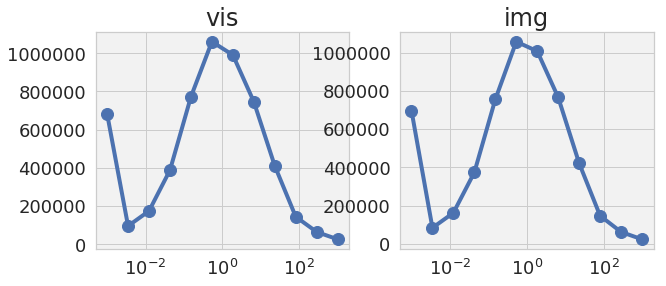

In [27]:
lambdas = models['lambda_params']
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lambdas, [np.sum(pcp_best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log')
plt.title('vis')
plt.subplot(1,2,2)
plt.plot(lambdas, [np.sum(img_best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log')
plt.title('img')

## Display the cross-validated validation accuracy over the whole dataset for each training run

argmax cc = 175505
max cc = 0.776447
sum(cc>.16) = 33547
argmax cc = 154445
max cc = 0.631091
sum(cc>.16) = 35744


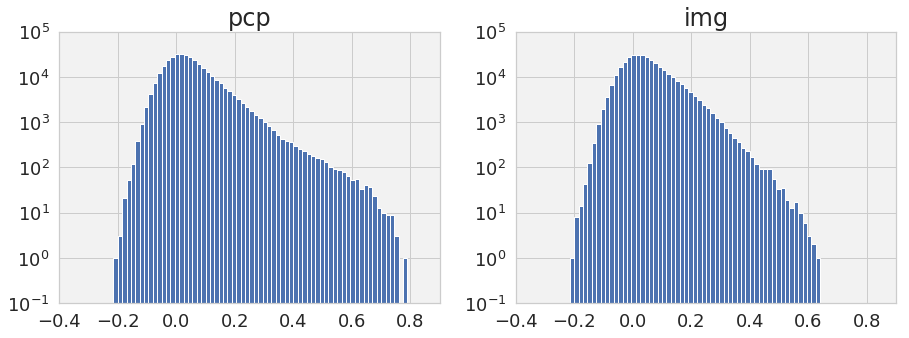

In [28]:
plt.figure(figsize=(15,5))
for i,run in enumerate(voxels.keys()):
    val_cc = np.nan_to_num(models[run]['val_cc'])
    aidx = np.argmax(val_cc)
    vidx = np.max(val_cc)
    print "argmax cc = %d" % aidx
    print "max cc = %f" % vidx
    print "sum(cc>.16) = %d" % np.sum(map(lambda x: x > 0.16, val_cc))
    plt.subplot(1,2,i+1)
    _=plt.hist(val_cc, bins=100, range=(-.5, 1.))
    plt.title(run)
    plt.yscale('log')
    plt.ylim([10**-1, 10**5])
    plt.xlim([-.4, 0.9])

## Save the models to disk

In [29]:
model_file_name = output_dir + "fwrf_%s_%s_data.pkl" % (subject, timestamp)
model_file = open(model_file_name, 'wb')
pickle.dump(models, model_file)
model_file.close()
print model_file_name

/home/styvesg/Documents/PostDoc/GitRepo/imagery-clean/output/LF_new/fwrf_LF_Jan-08-2020_1344_data.pkl


[back to top](#back_to_top)

## Full validation nifty maps

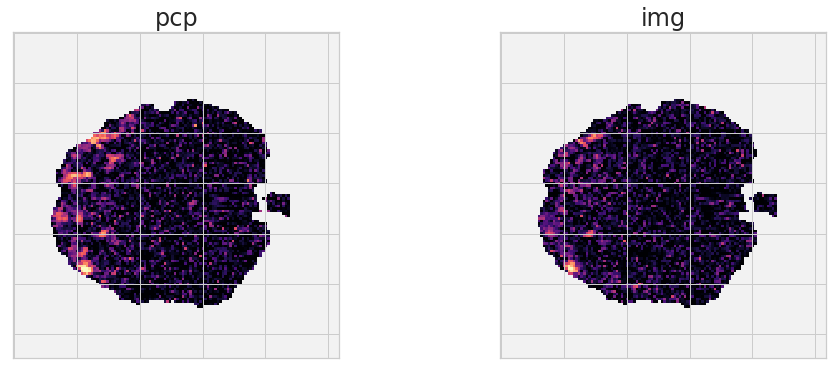

In [30]:
fig = plt.figure(figsize=(16,6))
for i,run in enumerate(voxels.keys()):
    val_cc = np.nan_to_num(models[run]['val_cc'])
    plt.subplot(1,len(voxels),i+1)
    volume_cc = view_data(voxel_grid, voxel_idx, val_cc, save_to=output_dir + 'fwrf_%s_%s_%s_val_cc' % (subject, run, timestamp))
    plt.imshow(volume_cc[:,:,15], cmap='magma', interpolation='None')
    plt.title(run)
    plt.clim([0, 0.6])
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])

## Picture validation maps nifty maps

In [31]:
from   src.load_data import mask_grayscale_cue
pic_data = mask_grayscale_cue(stim_data)

pcp_pic_data = pic_data[pcp_mask]
img_pic_data = pic_data[img_mask]

In [32]:
pcp_pic_fmaps, freq, env, ori, freq_rlist, ori_rlist, fmaps_sizes, nf = fs.create_gabor_feature_maps(\
    pcp_pic_data,  gabor_params=gabor_params, nonlinearity=log_act_func)

{'pix_per_cycle': 4.13, 'cycles_per_radius': 1.0, 'deg_per_stimulus': 16.000002847402424, 'n_colors': 1, 'complex_cell': True, 'num_sp_freq': 12, 'diams_per_filter': 4.0, 'highest_sp_freq': 11.0, 'n_orientations': 4, 'lowest_sp_freq': 0.35}
allocating memory for feature maps
constructing feature maps
feature 0 took 0.186311 s.
feature 1 took 0.195440 s.
feature 2 took 0.214843 s.
feature 3 took 0.254032 s.
feature 4 took 0.323923 s.
feature 5 took 0.362435 s.
feature 6 took 0.521011 s.
feature 7 took 0.801766 s.
feature 8 took 1.318521 s.
feature 9 took 2.237711 s.
feature 10 took 3.939970 s.
feature 11 took 7.129321 s.
feature 12 took 0.173151 s.
feature 13 took 0.182965 s.
feature 14 took 0.198393 s.
feature 15 took 0.233538 s.
feature 16 took 0.286108 s.
feature 17 took 0.367485 s.
feature 18 took 0.525492 s.
feature 19 took 0.808072 s.
feature 20 took 1.319861 s.
feature 21 took 2.255994 s.
feature 22 took 3.958248 s.
feature 23 took 7.178370 s.
feature 24 took 0.173891 s.
feature 

In [33]:
pic_mst_data,_,_ = fwrf.model_space_tensor(pcp_pic_fmaps, rf_models, env, nonlinearity=None, \
                zscore=True, mst_avg=pcp_mst_avg, mst_std=pcp_mst_std, trn_size=len(pcp_pic_data), epsilon=1e-6,\
                batches=(512, nx*ny), view_angle=view_angle, verbose=True, dry_run=False)

CREATING SYMBOLS

> feature map candidates 0 with shape (1, 441, 23, 23)
> feature map candidates 1 with shape (1, 441, 32, 32)
> feature map candidates 2 with shape (1, 441, 43, 43)
> feature map candidates 3 with shape (1, 441, 59, 59)
> feature map candidates 4 with shape (1, 441, 81, 81)
> feature map candidates 5 with shape (1, 441, 111, 111)
> feature map candidates 6 with shape (1, 441, 152, 152)
> feature map candidates 7 with shape (1, 441, 207, 207)
> feature map candidates 8 with shape (1, 441, 284, 284)
> feature map candidates 9 with shape (1, 441, 388, 388)
> feature map candidates 10 with shape (1, 441, 531, 531)
> feature map candidates 11 with shape (1, 441, 727, 727)
  total number of feature maps = 48, in 12 layers
  feature map candidate using approx 1906.7 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.484Gb of RAM!
>> Will be divided in chunks of 0.040Gb of VRAM!

COMPILING...
0.86 seconds to compile theano functions

Preco

100%|██████████| 12/12 [04:13<00:00, 21.17s/it]

5292 mst candidate responses took 254.003s @ 20.834 models/s
Z-scoring modelspace tensor...
Using provided z-scoring values.



12it [00:00, 13.13it/s]


In [34]:
pic_val = {}
for i,run in enumerate(voxels.keys()):
    pic_val[run] = {}
    val_pred = fwrf.kout_get_prediction_from_mst(pic_mst_data, models[run], batches=(512, ns*ny*nx))
    pic_val[run]['val_cc'] = fwrf.prediction_accuracy(val_pred, voxels[run])

100%|██████████| 347032/347032 [00:27<00:00, 12492.35it/s]


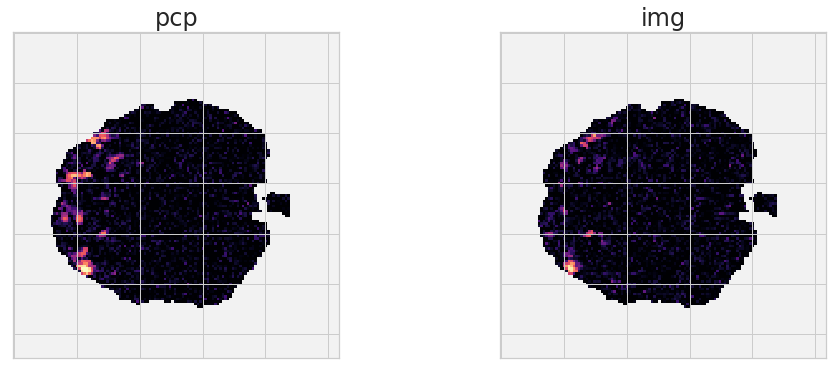

In [35]:
fig = plt.figure(figsize=(16,6))
for i,run in enumerate(voxels.keys()):
    val_cc = np.nan_to_num(pic_val[run]['val_cc'])
    plt.subplot(1,len(voxels),i+1)
    volume_cc = view_data(voxel_grid, voxel_idx, val_cc, save_to=output_dir + 'fwrf_%s_%s_%s_pic_cc' % (subject, run, timestamp))
    plt.imshow(volume_cc[:,:,15], cmap='magma', interpolation='None')
    plt.title(run)
    plt.clim([0, 0.6])
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])

## Vision data predicts imagery data?

In [13]:
nv = pcp_voxel_data.shape[1]
full_cc = np.zeros(shape=(nv))
for v in tqdm(range(nv)):
    full_cc[v] = np.corrcoef(pcp_voxel_data[:,v], img_voxel_data[:,v])[0,1]

100%|██████████| 349839/349839 [00:23<00:00, 14841.38it/s]


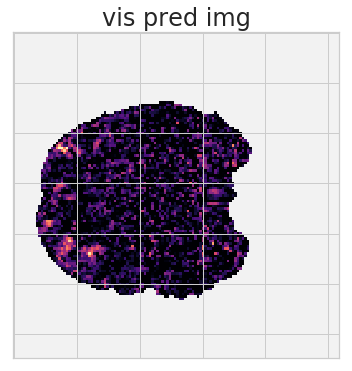

In [14]:
volume_cc = view_data(voxel_grid, voxel_idx, full_cc, save_to=output_dir + "%s_vis_pred_img.nii" % (subject))

fig = plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(volume_cc[:,:,15], cmap='magma', interpolation='None')
plt.title('vis pred img')
plt.clim([0, .4])
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])